In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/usa-states-geojson/us-states.json
/kaggle/input/usa-states-geojson/usa_population_2019.csv
/kaggle/input/superstore-dataset-final/Sample - Superstore.csv


### Preprocessing of Data

In [2]:
df = pd.read_csv('../input/superstore-dataset-final/Sample - Superstore.csv', encoding='windows-1252')

In [3]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [4]:
df["Ship Date"] = pd.DatetimeIndex(df['Ship Date'])
df["year"] = pd.DatetimeIndex(df['Ship Date']).year
df["month"] = pd.DatetimeIndex(df['Ship Date']).month
df["day"] = pd.DatetimeIndex(df['Ship Date']).day
df = df.sort_values(by = "Ship Date")

In [5]:
df.dtypes

Row ID                    int64
Order ID                 object
Order Date               object
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
year                      int64
month                     int64
day                       int64
dtype: object

# Context Problem

#### With growing demands and cut-throat competitions in the market, a Superstore Giant is seeking your knowledge in understanding what works best for them. They would like to understand which products, regions, categories and customer segments they should target or avoid.


## Sales Analysis

First we can observe and analyze the Sales Growth during the period from 2014-2017 

First the number of Sales during the period from 2014-2017

There is a growth in the number of Sales done throught the period from 2014 to 2017. We can also visualize this growth of the number of sales in a series plot:

In [6]:
## Creating the counts of sales per day DataFrame
sales_per_date = pd.DataFrame(df["Ship Date"].value_counts())

sales_per_date.reset_index(inplace=True)
sales_per_date = sales_per_date.rename(columns = {'index':'date', 'Ship Date': 'quantity'})

sales_per_date = sales_per_date.sort_values(by = "date")

# Creating a Dataframe with all the days of the year
x_dates = pd.date_range(start='2014-01-07', end='2018-01-05')
all_dates = {'date': x_dates, 'quantity': 0}
all_dates_df = pd.DataFrame(all_dates)

concat_dates = pd.concat([sales_per_date, all_dates_df])

ships_per_date = pd.DataFrame(concat_dates.groupby('date')['quantity'].sum())

ships_per_date.reset_index(inplace=True)
ships_per_date = ships_per_date.rename(columns = {'index':'date'})

ships_per_date = ships_per_date.sort_values(by = "date")

ships_per_date["year"] = pd.DatetimeIndex(ships_per_date['date']).year
ships_per_date["month"] = pd.DatetimeIndex(ships_per_date['date']).month

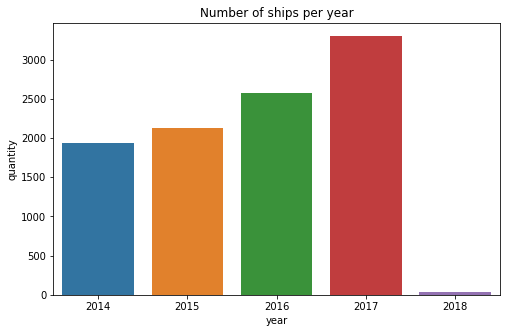

In [7]:
ships_per_year = ships_per_date.groupby("year").sum()["quantity"]

plt.figure(figsize = (8,5))
sns.barplot(x = ships_per_year.index, y = ships_per_year)
plt.title("Number of ships per year")
plt.show()

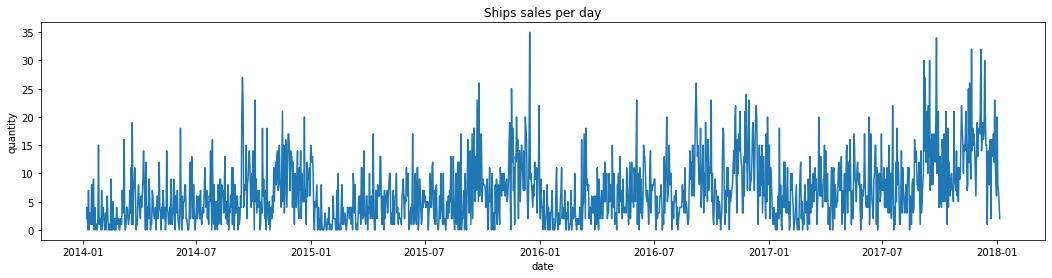

In [8]:
## plotting the dataframe
plt.figure(figsize = (18,4))
sns.lineplot(data = ships_per_date, x = "date", y = "quantity")
plt.title("Ships sales per day")
plt.show()

We can visualize it better if we obtain the number of sales per month

In [9]:
ships_per_month_sum= pd.DataFrame(ships_per_date.groupby(["month", "year"]).sum()["quantity"])
ships_per_month_sum.reset_index(inplace=True)

ships_per_month_sum =ships_per_month_sum.sort_values(by=(["year", "month"]))
monthly_sales_sum = pd.DataFrame()
monthly_sales_sum["date"] = ships_per_month_sum.year.astype(str) + '-' + ships_per_month_sum.month.astype(str)
monthly_sales_sum["quantity"] = ships_per_month_sum.quantity


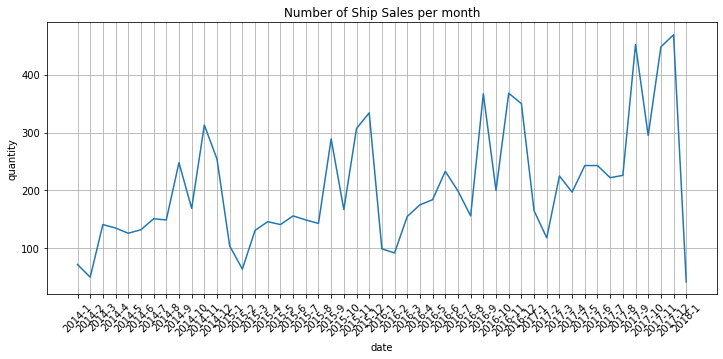

In [10]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_sales_sum, x = "date", y="quantity")
plt.xticks(rotation = 45)
plt.title("Number of Ship Sales per month")
plt.grid()
plt.show()

We can see a seasonlaity in the number of sales per month. Also we can observe a small growing trend throughout the years, regarding the number of sales per month. 

Now we can analyze the income from the sales from the period from 2014-2017

In [11]:
sales_dates_sum = pd.DataFrame(df.groupby(["Ship Date"]).sum()["Sales"])
sales_dates_sum.reset_index(inplace=True)
sales_dates_sum = sales_dates_sum.sort_values(by = "Ship Date")

sales_dates_sum["year"] = pd.DatetimeIndex(sales_dates_sum['Ship Date']).year
sales_dates_sum["month"] = pd.DatetimeIndex(sales_dates_sum['Ship Date']).month


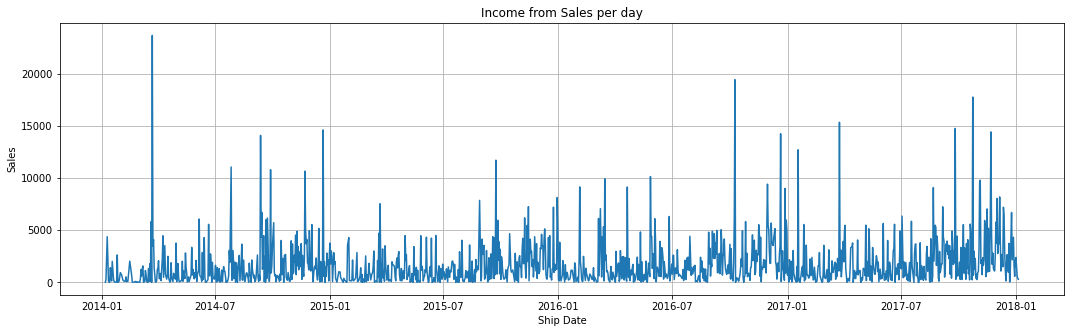

In [12]:
plt.figure(figsize = (18,5))
sns.lineplot(data = sales_dates_sum, x = "Ship Date", y = "Sales")
plt.title("Income from Sales per day")
plt.grid()
plt.show()

In [13]:
sales_per_month_sum= pd.DataFrame(sales_dates_sum.groupby(["month", "year"]).sum()["Sales"])
sales_per_month_sum.reset_index(inplace=True)
sales_per_month_sum

sales_month_sum = pd.DataFrame()
sales_month_sum["date"] = sales_per_month_sum.year.astype(str) + '-' + sales_per_month_sum.month.astype(str)
sales_month_sum["sales"] = sales_per_month_sum.Sales


We can obtain the total Income from Sales per month, in order to visualize it better

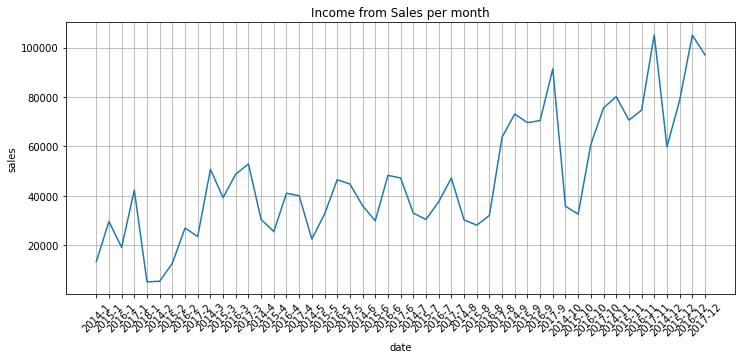

In [14]:
plt.figure(figsize = (12,5))
sns.lineplot(data = sales_month_sum, x = "date", y="sales")
plt.xticks(rotation = 45)
plt.title("Income from Sales per month")
plt.grid()
plt.show()

We can observe an increase in the income of the sales, that may be correlated to the increase in the number of ships donde throughout the period of 2014 to 2017

We can also analyze the mean income from the sales from the period from 2014-2017


In [15]:
sales_dates_mean = pd.DataFrame(df.groupby(["Ship Date"]).mean()["Sales"])
sales_dates_mean.reset_index(inplace=True)
sales_dates_mean = sales_dates_mean.sort_values(by = "Ship Date")

sales_dates_mean["year"] = pd.DatetimeIndex(sales_dates_mean['Ship Date']).year
sales_dates_mean["month"] = pd.DatetimeIndex(sales_dates_mean['Ship Date']).month

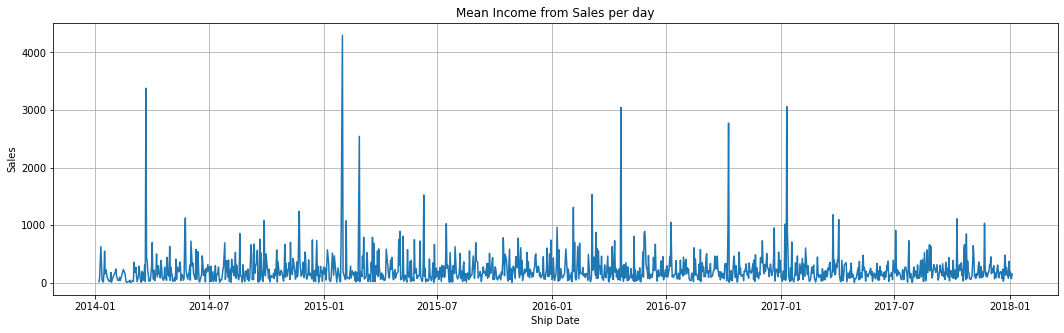

In [16]:
plt.figure(figsize = (18,5))
sns.lineplot(data = sales_dates_mean, x = "Ship Date", y = "Sales")
plt.grid()
plt.title("Mean Income from Sales per day")
plt.show()

In [17]:
sales_per_month_mean = pd.DataFrame(sales_dates_mean.groupby(["month", "year"]).mean()["Sales"])
sales_per_month_mean.reset_index(inplace=True)
sales_per_month_mean

sales_month_mean = pd.DataFrame()
sales_month_mean["date"] = sales_per_month_mean.year.astype(str) + '-' + sales_per_month_mean.month.astype(str)
sales_month_mean["sales"] = sales_per_month_mean.Sales


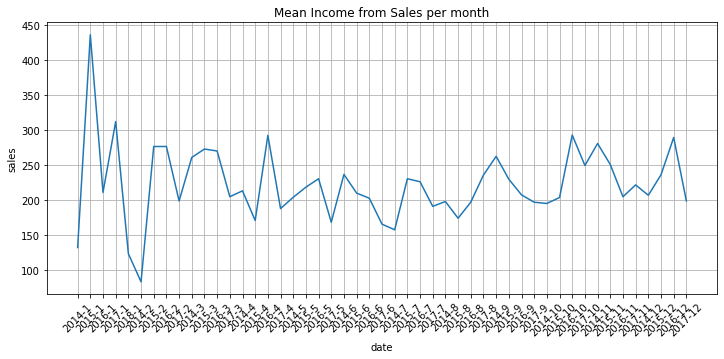

In [18]:
plt.figure(figsize = (12,5))
sns.lineplot(data = sales_month_mean, x = "date", y="sales")
plt.xticks(rotation = 45)
plt.title("Mean Income from Sales per month")
plt.grid()
plt.show()

The mean Income from the sales is pretty similar throughout the years, so the recent growth is coming from the growth in the amount of sales, not an increase in the prices of the Sales.

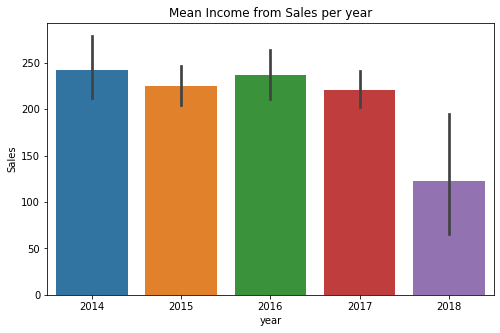

In [19]:
plt.figure(figsize = (8,5))
sns.barplot(data = df, x = "year", y = "Sales")
plt.title("Mean Income from Sales per year")
plt.show()

## Profit Analysis

Total Profit gained from the period of 2014-2017

In [20]:
profit_dates_sum = pd.DataFrame(df.groupby(["Ship Date"]).sum()["Profit"])
profit_dates_sum.reset_index(inplace=True)
profit_dates_sum = profit_dates_sum.sort_values(by = "Ship Date")

profit_dates_sum["year"] = pd.DatetimeIndex(profit_dates_sum['Ship Date']).year
profit_dates_sum["month"] = pd.DatetimeIndex(profit_dates_sum['Ship Date']).month

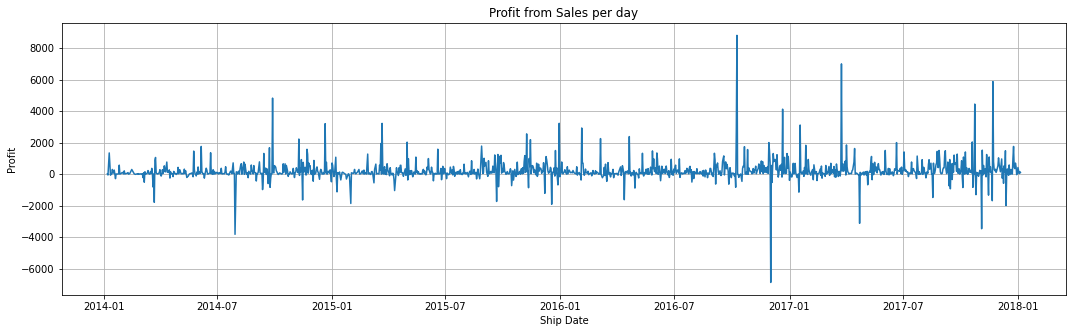

In [21]:
plt.figure(figsize = (18,5))
sns.lineplot(data = profit_dates_sum, x = "Ship Date", y = "Profit")
plt.title("Profit from Sales per day")
plt.grid()
plt.show()

In [22]:
profit_per_month_sum = pd.DataFrame(profit_dates_sum.groupby(["month", "year"]).sum()["Profit"])
profit_per_month_sum.reset_index(inplace=True)
profit_per_month_sum

profit_monthly_sum = pd.DataFrame()
profit_monthly_sum["date"] = profit_per_month_sum.year.astype(str) + '-' + profit_per_month_sum.month.astype(str)
profit_monthly_sum["profit"] = profit_per_month_sum.Profit


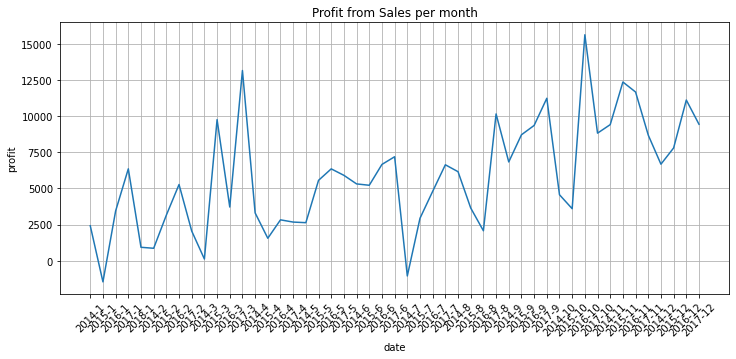

In [23]:
plt.figure(figsize = (12,5))
sns.lineplot(data = profit_monthly_sum, x = "date", y="profit")
plt.xticks(rotation = 45)
plt.title("Profit from Sales per month")
plt.grid()
plt.show()

> We can observe that, as well as a growth in the income from the sales, there is a growth in the profit from the sales

Mean Profit gained from the period of 2014-2017

In [24]:
profit_dates_mean = pd.DataFrame(df.groupby(["Ship Date"]).mean()["Profit"])
profit_dates_mean.reset_index(inplace=True)
profit_dates_mean = profit_dates_mean.sort_values(by = "Ship Date")

profit_dates_mean["year"] = pd.DatetimeIndex(profit_dates_mean['Ship Date']).year
profit_dates_mean["month"] = pd.DatetimeIndex(profit_dates_mean['Ship Date']).month

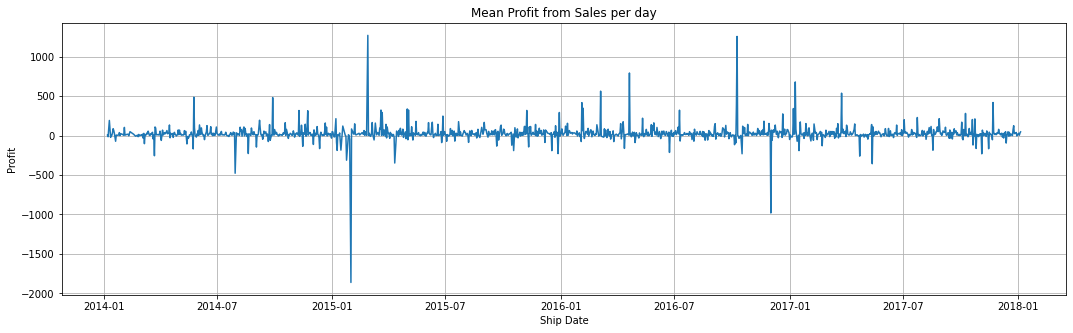

In [25]:
plt.figure(figsize = (18,5))
sns.lineplot(data = profit_dates_mean, x = "Ship Date", y = "Profit")
plt.title("Mean Profit from Sales per day")
plt.grid()
plt.show()

In [26]:
profit_per_month_mean = pd.DataFrame(profit_dates_mean.groupby(["month", "year"]).mean()["Profit"])
profit_per_month_mean.reset_index(inplace=True)
profit_per_month_mean

profit_monthly_mean = pd.DataFrame()
profit_monthly_mean["date"] = profit_per_month_mean.year.astype(str) + '-' + profit_per_month_mean.month.astype(str)
profit_monthly_mean["profit"] = profit_per_month_mean.Profit


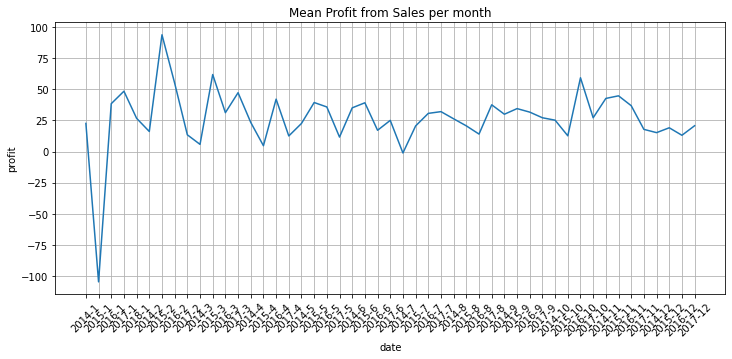

In [27]:
plt.figure(figsize = (12,5))
sns.lineplot(data = profit_monthly_mean, x = "date", y="profit")
plt.xticks(rotation = 45)
plt.title("Mean Profit from Sales per month")
plt.grid()
plt.show()

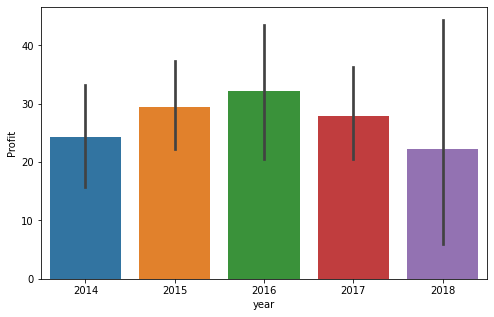

In [28]:
plt.figure(figsize =(8,5))
sns.barplot(data = df, x = "year", y = "Profit")
plt.show()

> Also a similar mean profit per year

## Regions Analysis

In [29]:
df.Region.unique()

array(['South', 'Central', 'West', 'East'], dtype=object)

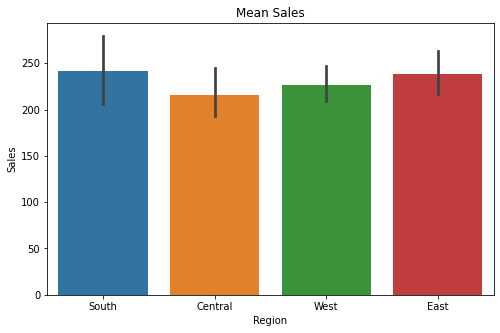

In [30]:
plt.figure(figsize = (8,5))
sns.barplot(data = df, x = "Region", y = "Sales")
plt.title("Mean Sales")
plt.show()

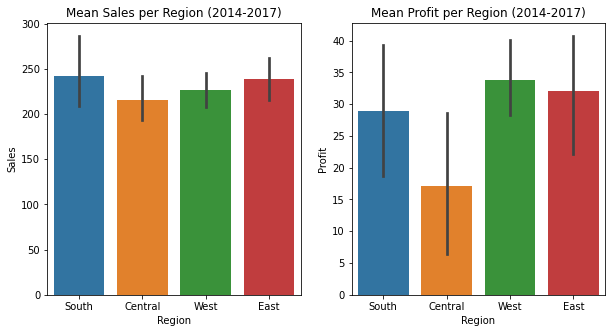

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(data = df, ax = axes[0],x = "Region", y = "Sales")
axes[0].set_title("Mean Sales per Region (2014-2017)")

sns.barplot(data = df, ax = axes[1],x = "Region", y = "Profit")
axes[1].set_title("Mean Profit per Region (2014-2017)")

plt.show()

> The Mean Sales Income from all the Regions seems to be similar, between the four regions. But we can say that the highest mean sales income comes from clients from the South Region. And in terms of Profit, the most profitables regiosn are the West and the East, and the Central region mean profitability is low compared to other regions. 

We can visualize the Sales and Profits per region per year

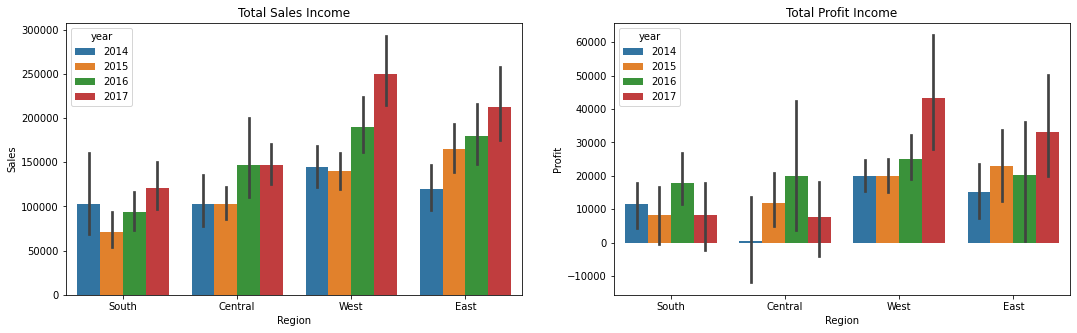

In [32]:
from numpy import sum
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data = df[df.year != 2018],  ax=axes[0], x = "Region", y = "Sales", hue = "year", estimator = sum)
axes[0].set_title("Total Sales Income")

# sns.stripplot(data = df,  ax=axes[1],x= "Segment", y = "Sales")
sns.barplot(data = df[df.year != 2018],  ax=axes[1], x = "Region", y = "Profit", hue = "year", estimator = sum)
axes[1].set_title("Total Profit Income")


plt.show()

> In total Sales there is a growth in all regions. In total profits there is only a growth in the West and East Regions, because the South and Central Regions have irregular growth. 

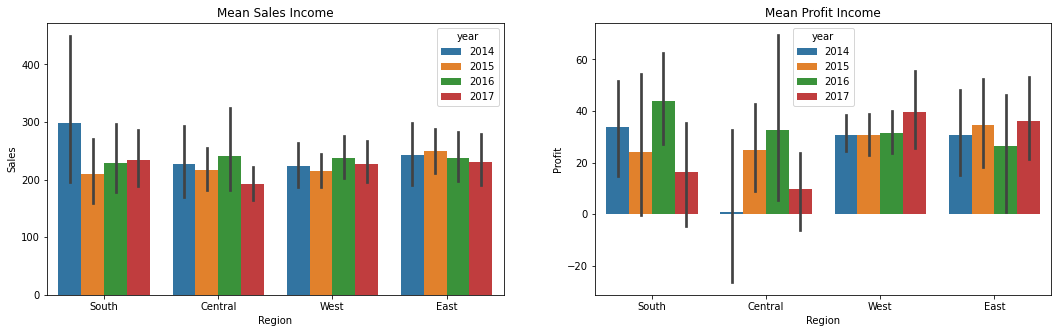

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data = df[df.year != 2018],  ax=axes[0], x = "Region", y = "Sales", hue = "year", estimator = np.mean)
axes[0].set_title("Mean Sales Income")

# sns.stripplot(data = df,  ax=axes[1],x= "Segment", y = "Sales")
sns.barplot(data = df[df.year != 2018],  ax=axes[1], x = "Region", y = "Profit", hue = "year", estimator = np.mean)
axes[1].set_title("Mean Profit Income")


plt.show()

> The mean Sales seems to be pretty stable in all the regions throughout the years. The mean profit seems stable ins West and East regions, but there is a decrease in the mean Profit coming from the clients from the South and Central Regions

In [34]:
dates_region_sum = df.groupby(["Ship Date", "Region"])[["Sales", "Profit"]].sum()
dates_region_sum.reset_index(inplace=True)
dates_region_sum = dates_region_sum.sort_values(by = "Ship Date")
dates_region_sum["year"] = pd.DatetimeIndex(dates_region_sum['Ship Date']).year
dates_region_sum["month"] = pd.DatetimeIndex(dates_region_sum['Ship Date']).month


dates_region_mean = df.groupby(["Ship Date", "Region"])[["Sales", "Profit"]].mean()
dates_region_mean.reset_index(inplace=True)
dates_region_mean = dates_region_sum.sort_values(by = "Ship Date")
dates_region_mean["year"] = pd.DatetimeIndex(dates_region_mean['Ship Date']).year
dates_region_mean["month"] = pd.DatetimeIndex(dates_region_mean['Ship Date']).month


In [35]:
region_per_month_sum = pd.DataFrame(dates_region_sum.groupby(["month", "year", "Region"])[["Sales", "Profit"]].sum())
region_per_month_sum.reset_index(inplace=True)
region_per_month_sum
region_per_month_sum =region_per_month_sum.sort_values(by=(["year", "month"]))

monthly_regions_sum = pd.DataFrame()
monthly_regions_sum["date"] = region_per_month_sum.year.astype(str) + '-' + region_per_month_sum.month.astype(str)
monthly_regions_sum["sales"] = region_per_month_sum.Sales
monthly_regions_sum["profit"] = region_per_month_sum.Profit
monthly_regions_sum["region"] = region_per_month_sum.Region

In [36]:
region_per_month_mean = pd.DataFrame(dates_region_mean.groupby(["month", "year", "Region"])[["Sales", "Profit"]].mean())
region_per_month_mean.reset_index(inplace=True)
region_per_month_mean
region_per_month_mean =region_per_month_mean.sort_values(by=(["year", "month"]))

monthly_regions_mean = pd.DataFrame()
monthly_regions_mean["date"] = region_per_month_mean.year.astype(str) + '-' + region_per_month_mean.month.astype(str)
monthly_regions_mean["sales"] = region_per_month_mean.Sales
monthly_regions_mean["profit"] = region_per_month_mean.Profit
monthly_regions_mean["region"] = region_per_month_mean.Region

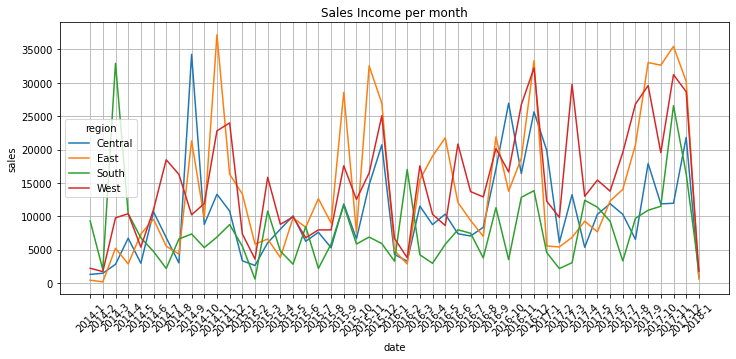

In [37]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_regions_sum, x = "date", y="sales", hue = "region")
plt.xticks(rotation = 45)
plt.title("Sales Income per month")
plt.grid()
plt.show()

<AxesSubplot:xlabel='sales', ylabel='Density'>

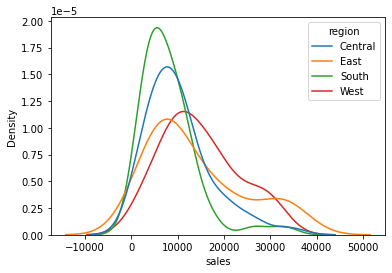

In [38]:
sns.kdeplot(data = monthly_regions_sum, x = "sales", hue = "region")

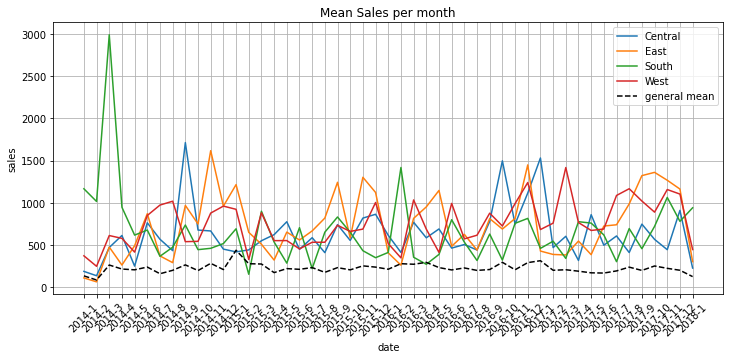

In [39]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_regions_mean, x = "date", y="sales", hue = "region")
sns.lineplot(data = sales_month_mean, x = "date", y="sales", linestyle="--", color ="black", label="general mean")
plt.xticks(rotation = 45)
plt.title("Mean Sales per month")
plt.grid()
plt.show()

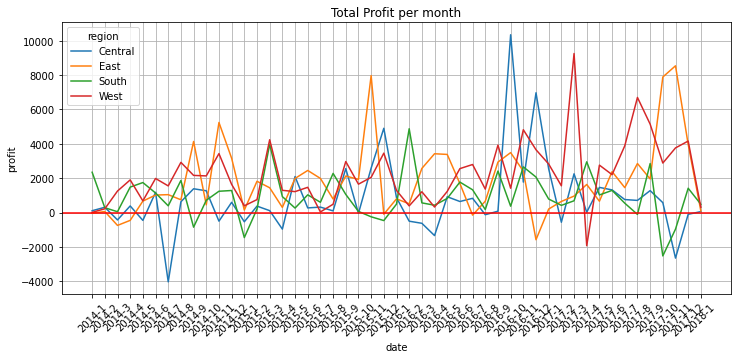

In [40]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_regions_sum, x = "date", y="profit", hue = "region")
plt.xticks(rotation = 45)
plt.title("Total Profit per month")
plt.axhline(y=0, color = "red")

plt.grid()
plt.show()

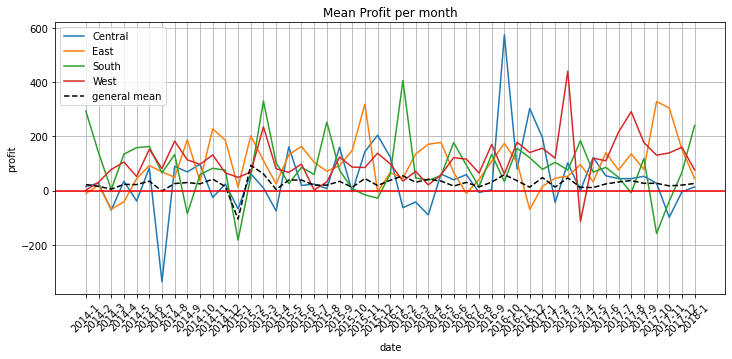

In [41]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_regions_mean, x = "date", y="profit", hue = "region")
sns.lineplot(data = profit_monthly_mean, x = "date", y="profit", linestyle="--", color ="black", label="general mean")
plt.xticks(rotation = 45)
plt.title("Mean Profit per month")
plt.axhline(y=0, color = "red")

plt.grid()
plt.show()

<AxesSubplot:xlabel='profit', ylabel='Density'>

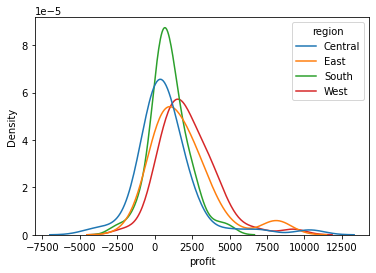

In [42]:
sns.kdeplot(data = monthly_regions_sum, x = "profit", hue = "region")

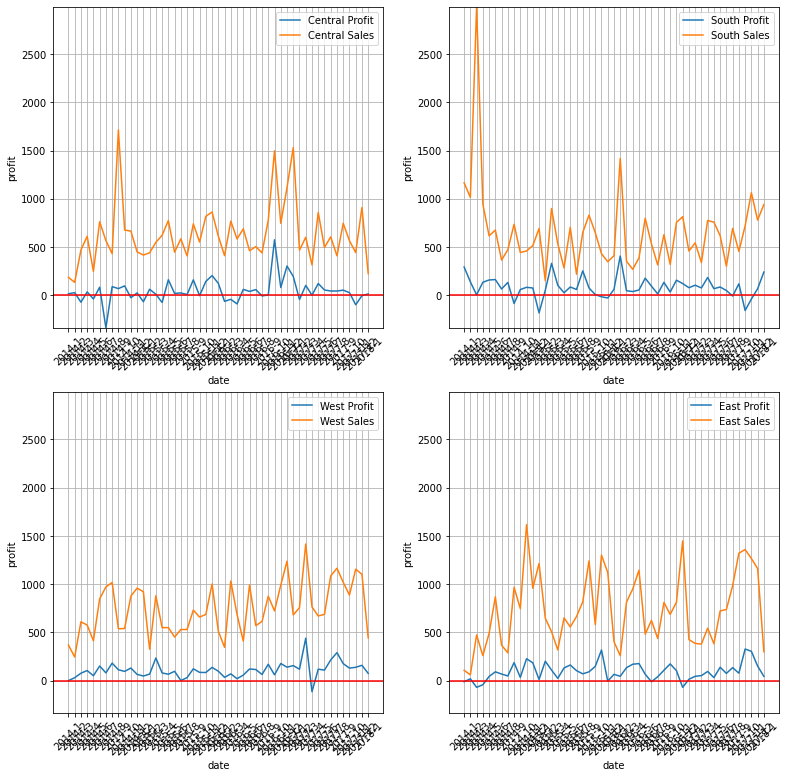

In [43]:
plt.subplots(2,2, figsize = (13,13))

plt.subplot(2,2,1)
sns.lineplot(data = monthly_regions_mean[monthly_regions_mean.region == "Central"], x = "date", y="profit", label="Central Profit")
sns.lineplot(data = monthly_regions_mean[monthly_regions_mean.region == "Central"], x = "date", y="sales", label="Central Sales")
plt.xticks(rotation = 45)
plt.ylim(min(monthly_regions_mean.profit), max(monthly_regions_mean.sales))
plt.axhline(y=0, color = "red")

plt.grid()

plt.subplot(2,2,2)
sns.lineplot(data = monthly_regions_mean[monthly_regions_mean.region == "South"], x = "date", y="profit", label="South Profit")
sns.lineplot(data = monthly_regions_mean[monthly_regions_mean.region == "South"], x = "date", y="sales", label="South Sales")
plt.xticks(rotation = 45)
plt.ylim(min(monthly_regions_mean.profit), max(monthly_regions_mean.sales))
plt.axhline(y=0, color = "red")

plt.grid()

plt.subplot(2,2,3)
sns.lineplot(data = monthly_regions_mean[monthly_regions_mean.region == "West"], x = "date", y="profit", label="West Profit")
sns.lineplot(data = monthly_regions_mean[monthly_regions_mean.region == "West"], x = "date", y="sales", label="West Sales")
plt.xticks(rotation = 45)
plt.ylim(min(monthly_regions_mean.profit), max(monthly_regions_mean.sales))

plt.axhline(y=0, color = "red")

plt.grid()

plt.subplot(2,2,4)
sns.lineplot(data = monthly_regions_mean[monthly_regions_mean.region == "East"], x = "date", y="profit", label="East Profit")
sns.lineplot(data = monthly_regions_mean[monthly_regions_mean.region == "East"], x = "date", y="sales", label="East Sales")
plt.xticks(rotation = 45)
plt.ylim(min(monthly_regions_mean.profit), max(monthly_regions_mean.sales))
plt.axhline(y=0, color = "red")

plt.grid()

plt.legend()
plt.show()

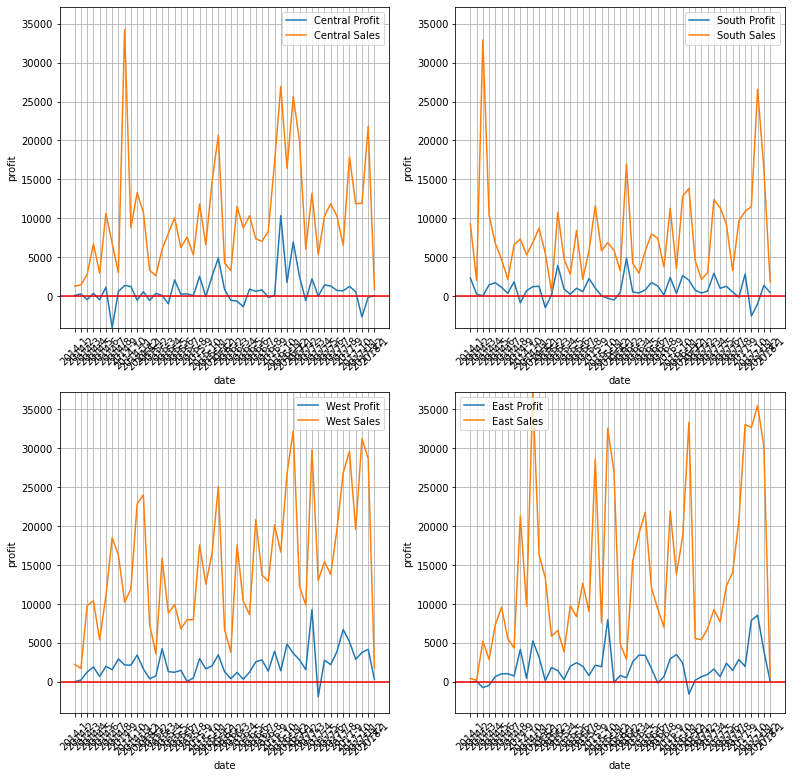

In [44]:
plt.subplots(2,2, figsize = (13,13))

plt.subplot(2,2,1)
sns.lineplot(data = monthly_regions_sum[monthly_regions_sum.region == "Central"], x = "date", y="profit", label="Central Profit")
sns.lineplot(data = monthly_regions_sum[monthly_regions_sum.region == "Central"], x = "date", y="sales", label="Central Sales")
plt.xticks(rotation = 45)
plt.ylim(min(monthly_regions_sum.profit), max(monthly_regions_sum.sales))
plt.axhline(y=0, color = "red")

plt.grid()

plt.subplot(2,2,2)
sns.lineplot(data = monthly_regions_sum[monthly_regions_sum.region == "South"], x = "date", y="profit", label="South Profit")
sns.lineplot(data = monthly_regions_sum[monthly_regions_sum.region == "South"], x = "date", y="sales", label="South Sales")
plt.xticks(rotation = 45)
plt.ylim(min(monthly_regions_sum.profit), max(monthly_regions_sum.sales))
plt.axhline(y=0, color = "red")

plt.grid()

plt.subplot(2,2,3)
sns.lineplot(data = monthly_regions_sum[monthly_regions_sum.region == "West"], x = "date", y="profit", label="West Profit")
sns.lineplot(data = monthly_regions_sum[monthly_regions_sum.region == "West"], x = "date", y="sales", label="West Sales")
plt.xticks(rotation = 45)
plt.ylim(min(monthly_regions_sum.profit), max(monthly_regions_sum.sales))

plt.axhline(y=0, color = "red")

plt.grid()

plt.subplot(2,2,4)
sns.lineplot(data = monthly_regions_sum[monthly_regions_sum.region == "East"], x = "date", y="profit", label="East Profit")
sns.lineplot(data = monthly_regions_sum[monthly_regions_sum.region == "East"], x = "date", y="sales", label="East Sales")
plt.xticks(rotation = 45)
plt.ylim(min(monthly_regions_sum.profit), max(monthly_regions_sum.sales))
plt.axhline(y=0, color = "red")

plt.grid()

plt.legend()
plt.show()

In [45]:
monthly_regions_sum["cost"] = monthly_regions_sum["sales"] - monthly_regions_sum["profit"]

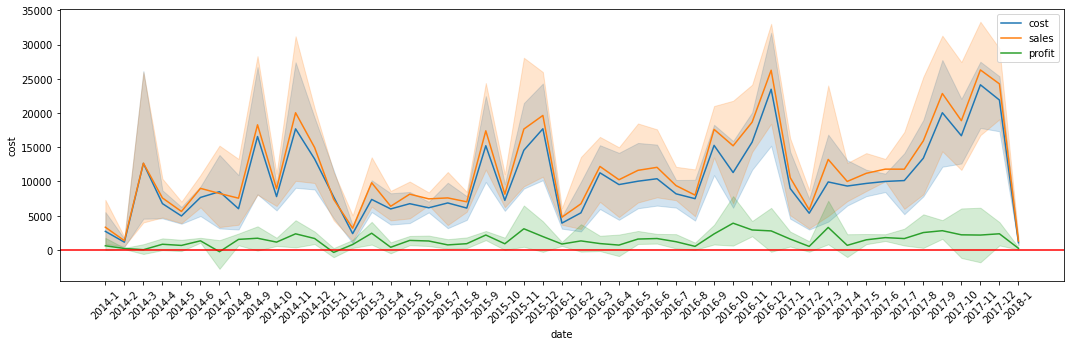

In [46]:
plt.figure(figsize = (18,5))
sns.lineplot(data = monthly_regions_sum, x = "date", y="cost", label = "cost")
sns.lineplot(data = monthly_regions_sum, x = "date", y = "sales", label = "sales")
sns.lineplot(data = monthly_regions_sum, x = "date", y = "profit", label = "profit")
plt.axhline(y=0, color = "red")
plt.xticks(rotation = 45)
plt.show()

> We can see that the mean cost (Sales - Profit) is really similar to the Sales, making the mean margin profit small compared with the mean sales. We could analyze further the reason behind the high costs, in order to increase the profit

## Categories Analysis

In [47]:
df.groupby("Category")[["Sales", "Profit"]].describe()

Sales                                                   \
                  count        mean          std    min     25%      50%   
Category                                                                   
Furniture        2121.0  349.834887   503.179145  1.892  47.040  182.220   
Office Supplies  6026.0  119.324101   382.182228  0.444  11.760   27.418   
Technology       1847.0  452.709276  1108.655848  0.990  68.016  166.160   

                                     Profit                                    \
                     75%        max   count       mean         std        min   
Category                                                                        
Furniture        435.168   4416.174  2121.0   8.699327  136.049246 -1862.3124   
Office Supplies   79.920   9892.740  6026.0  20.327050  164.887280 -3701.8928   
Technology       448.534  22638.480  1847.0  78.752002  428.816633 -6599.9780   

                                                       
                      25%      50%      75%       max  
Category                                               
Furniture       -12.84900   7.7748  33.7266  1013.127  
Office Supplies   2.10150   6.8824  19.4163  4946.370  
Technology        5.20365  25.0182  74.8946  8399.976

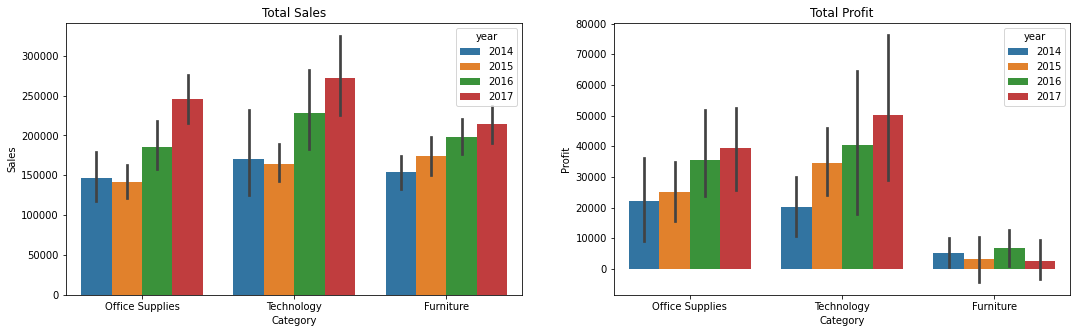

In [48]:
from numpy import sum
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data = df[df.year != 2018],  ax=axes[0], x = "Category", y = "Sales", hue = "year", estimator = sum)
axes[0].set_title("Total Sales")

sns.barplot(data = df[df.year != 2018],  ax=axes[1], x = "Category", y = "Profit", hue = "year", estimator = sum)
axes[1].set_title("Total Profit")

plt.show()

> We can see an increase in the income from the sales of all categories. 
> The most profitable product category is the Techonology category, followed by the Office Supplies. It seems that the furniture category products are not very profitable. 

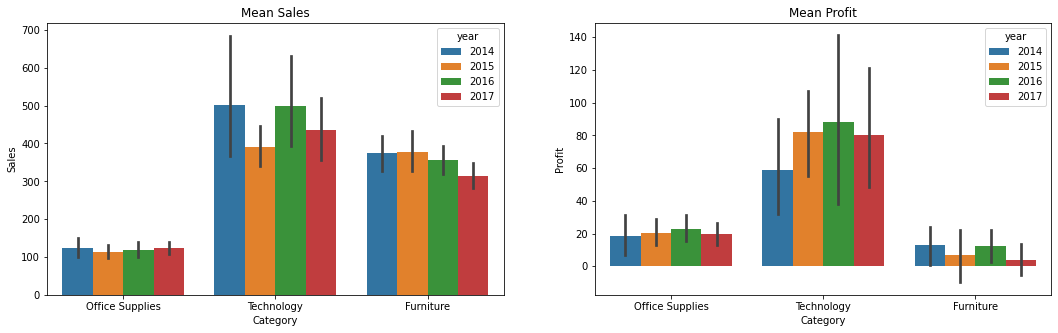

In [49]:
from numpy import mean
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data = df[df.year != 2018],  ax=axes[0], x = "Category", y = "Sales", hue = "year", estimator = mean)
axes[0].set_title("Mean Sales")

sns.barplot(data = df[df.year != 2018],  ax=axes[1], x = "Category", y = "Profit", hue = "year", estimator = mean)
axes[1].set_title("Mean Profit")

plt.show()

In [50]:
dates_cat_sum = df.groupby(["Ship Date", "Category"])[["Sales", "Profit"]].sum()
dates_cat_sum.reset_index(inplace=True)
dates_cat_sum = dates_cat_sum.sort_values(by = "Ship Date")
dates_cat_sum["year"] = pd.DatetimeIndex(dates_cat_sum['Ship Date']).year
dates_cat_sum["month"] = pd.DatetimeIndex(dates_cat_sum['Ship Date']).month


dates_cat_mean = df.groupby(["Ship Date", "Category"])[["Sales", "Profit"]].mean()
dates_cat_mean.reset_index(inplace=True)
dates_cat_mean = dates_cat_mean.sort_values(by = "Ship Date")
dates_cat_mean["year"] = pd.DatetimeIndex(dates_cat_mean['Ship Date']).year
dates_cat_mean["month"] = pd.DatetimeIndex(dates_cat_mean['Ship Date']).month

In [51]:
cats_per_month_sum = pd.DataFrame(dates_cat_sum.groupby(["month", "year", "Category"])[["Sales", "Profit"]].sum())
cats_per_month_sum.reset_index(inplace=True)
cats_per_month_sum
cats_per_month_sum =cats_per_month_sum.sort_values(by=(["year", "month"]))

monthly_cats_sum = pd.DataFrame()
monthly_cats_sum["date"] = cats_per_month_sum.year.astype(str) + '-' + cats_per_month_sum.month.astype(str)
monthly_cats_sum["sales"] = cats_per_month_sum.Sales
monthly_cats_sum["profit"] = cats_per_month_sum.Profit
monthly_cats_sum["category"] = cats_per_month_sum.Category

In [52]:
cats_per_month_mean = pd.DataFrame(dates_cat_mean.groupby(["month", "year", "Category"])[["Sales", "Profit"]].mean())
cats_per_month_mean.reset_index(inplace=True)
cats_per_month_mean
cats_per_month_mean =cats_per_month_mean.sort_values(by=(["year", "month"]))

monthly_cats_mean = pd.DataFrame()
monthly_cats_mean["date"] = cats_per_month_mean.year.astype(str) + '-' + cats_per_month_mean.month.astype(str)
monthly_cats_mean["sales"] = cats_per_month_mean.Sales
monthly_cats_mean["profit"] = cats_per_month_mean.Profit
monthly_cats_mean["category"] = cats_per_month_mean.Category

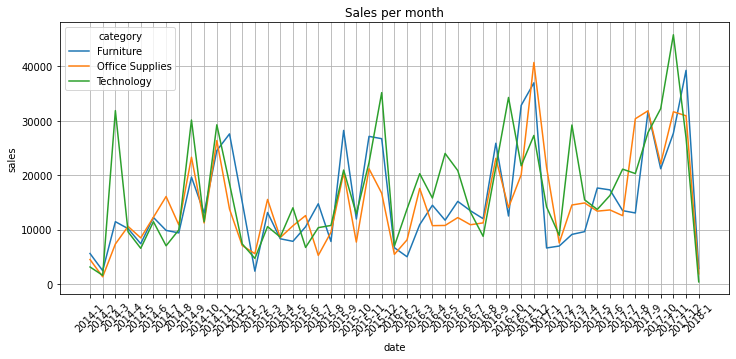

In [53]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_cats_sum, x = "date", y="sales", hue = "category")
plt.xticks(rotation = 45)
plt.title("Sales per month")
plt.grid()
plt.show()

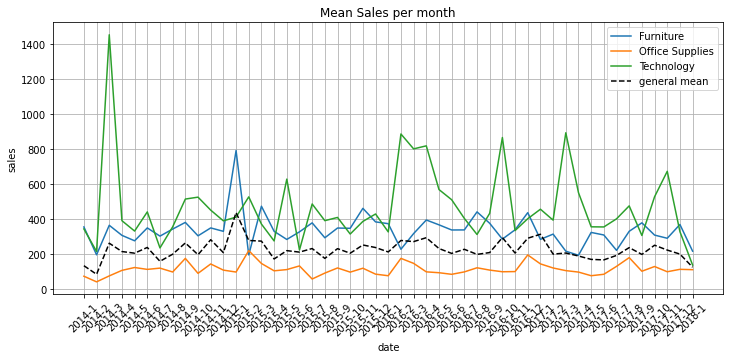

In [54]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_cats_mean, x = "date", y="sales", hue = "category")
sns.lineplot(data = sales_month_mean, x = "date", y="sales", linestyle="--", color ="black", label="general mean")
plt.xticks(rotation = 45)
plt.title("Mean Sales per month")
plt.grid()
plt.show()

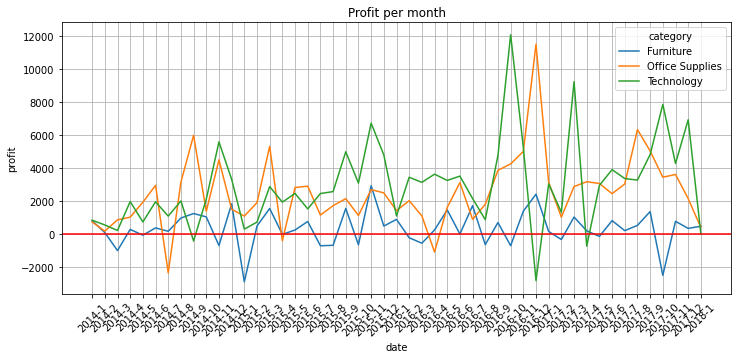

In [55]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_cats_sum, x = "date", y="profit", hue = "category")
plt.xticks(rotation = 45)
plt.axhline(y=0, color = "red")
plt.title("Profit per month")
plt.grid()
plt.show()

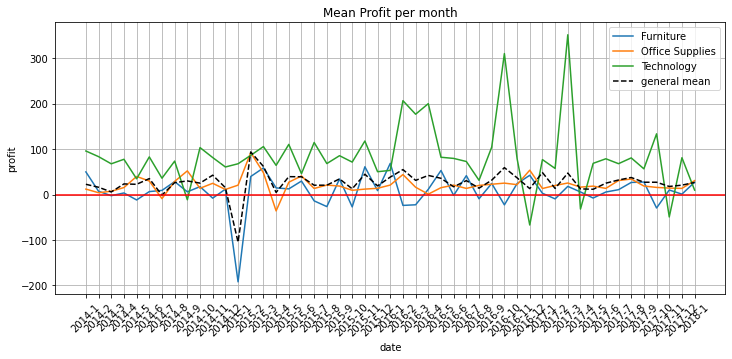

In [56]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_cats_mean, x = "date", y="profit", hue = "category")
sns.lineplot(data = profit_monthly_mean, x = "date", y="profit", linestyle="--", color ="black", label="general mean")
plt.xticks(rotation = 45)
plt.axhline(y=0, color = "red")
plt.title("Mean Profit per month")
plt.grid()
plt.show()

> The sales income from all the 3 categories are pretty similar, but in terms of profit the most profitable categories are the Office Supplies (because of their high demand) and the Technology products. The Furniture category doesn't seem to be a very profitable category, and it may be because of a high costs regarding the selling of this products, or it needs increase their demand in order to be profitable

In [57]:
monthly_cats_sum["cost"] = monthly_cats_sum["sales"] - monthly_cats_sum["profit"]

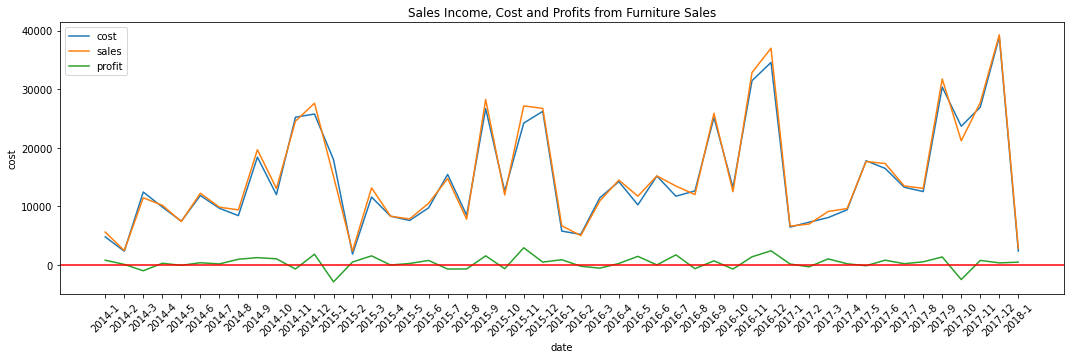

In [58]:
plt.figure(figsize = (18,5))
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Furniture"], x = "date", y="cost", label = "cost")
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Furniture"], x = "date", y = "sales", label = "sales")
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Furniture"], x = "date", y = "profit", label = "profit")
plt.axhline(y=0, color = "red")
plt.xticks(rotation = 45)
plt.title("Sales Income, Cost and Profits from Furniture Sales")
plt.show()

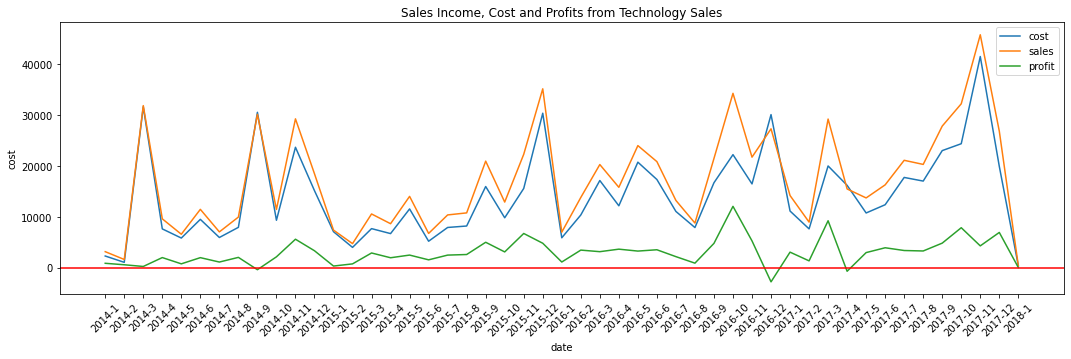

In [59]:
plt.figure(figsize = (18,5))
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Technology"], x = "date", y="cost", label = "cost")
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Technology"], x = "date", y = "sales", label = "sales")
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Technology"], x = "date", y = "profit", label = "profit")
plt.axhline(y=0, color = "red")
plt.xticks(rotation = 45)
plt.title("Sales Income, Cost and Profits from Technology Sales")
plt.show()

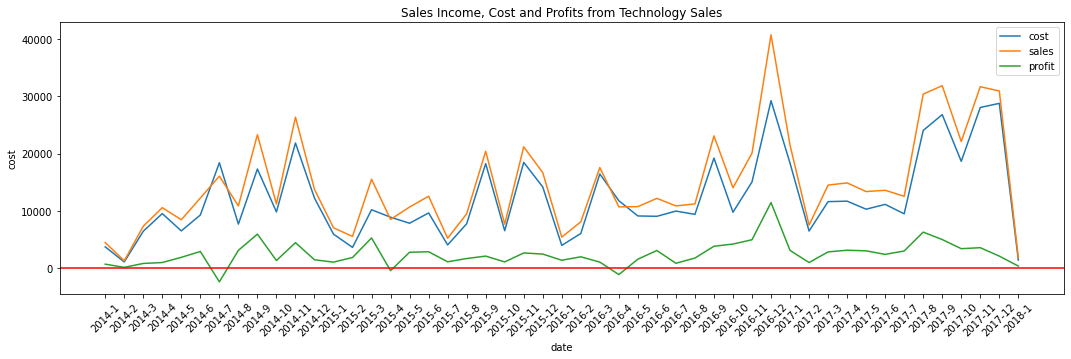

In [60]:
plt.figure(figsize = (18,5))
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Office Supplies"], x = "date", y="cost", label = "cost")
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Office Supplies"], x = "date", y = "sales", label = "sales")
sns.lineplot(data = monthly_cats_sum[monthly_cats_sum.category == "Office Supplies"], x = "date", y = "profit", label = "profit")
plt.axhline(y=0, color = "red")
plt.xticks(rotation = 45)
plt.title("Sales Income, Cost and Profits from Technology Sales")
plt.show()

> In terms of the cost (Sales - Profit), the Furniture products have a higher cost, which means a smaller profit margin. 

## Ship Mode Analysis

In [61]:
df.groupby("Ship Mode")[["Sales", "Profit"]].count()

,Sales,Profit
Ship Mode,,
First Class,1538,1538
Same Day,543,543
Second Class,1945,1945
Standard Class,5968,5968


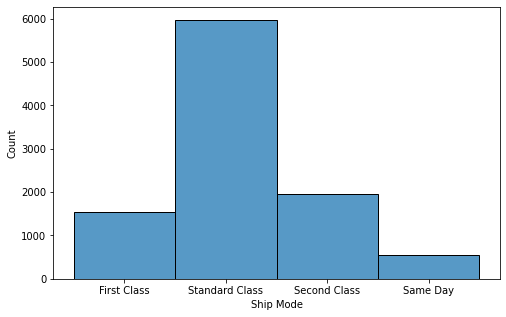

In [62]:
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = "Ship Mode")
plt.show()

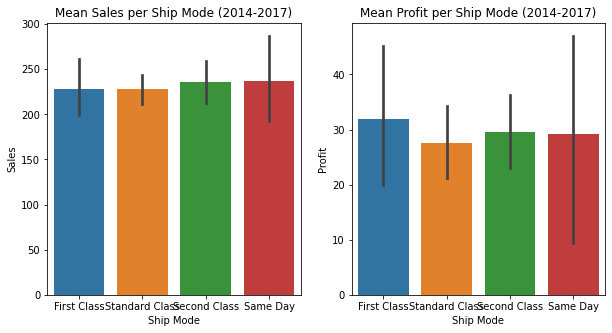

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(data = df, ax = axes[0],x = "Ship Mode", y = "Sales")
axes[0].set_title("Mean Sales per Ship Mode (2014-2017)")

sns.barplot(data = df, ax = axes[1],x = "Ship Mode", y = "Profit")
axes[1].set_title("Mean Profit per Ship Mode (2014-2017)")

plt.show()

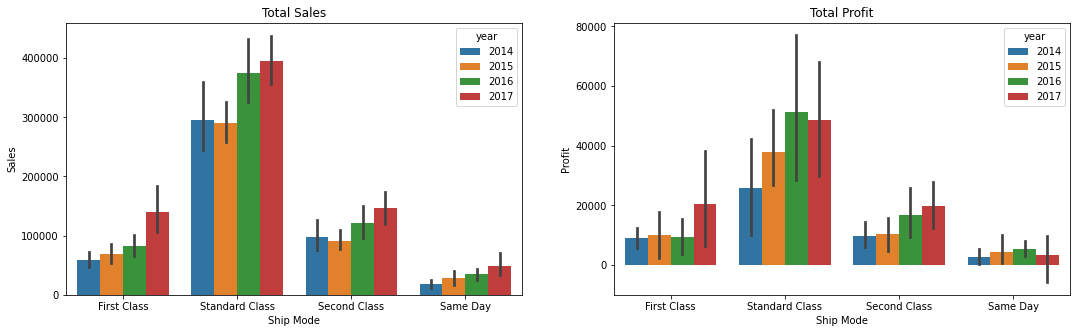

In [64]:
from numpy import sum
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data = df[df.year != 2018],  ax=axes[0], x = "Ship Mode", y = "Sales", hue = "year", estimator = sum)
axes[0].set_title("Total Sales")

sns.barplot(data = df[df.year != 2018],  ax=axes[1], x = "Ship Mode", y = "Profit", hue = "year", estimator = sum)
axes[1].set_title("Total Profit")

plt.show()

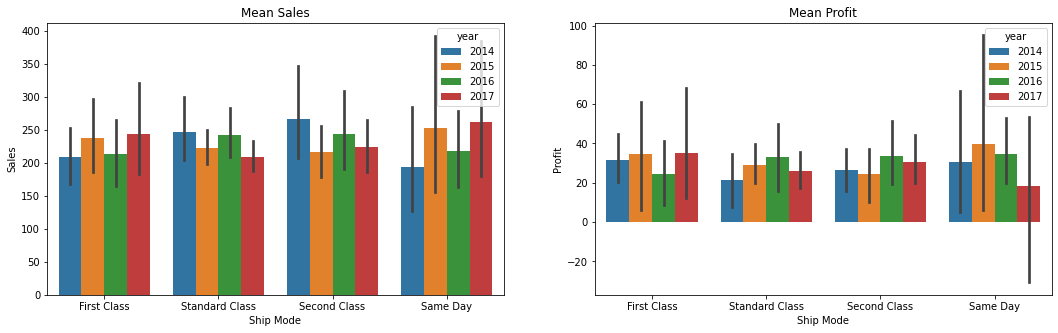

In [65]:
from numpy import mean
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data = df[df.year != 2018],  ax=axes[0], x = "Ship Mode", y = "Sales", hue = "year", estimator = mean)
axes[0].set_title("Mean Sales")

sns.barplot(data = df[df.year != 2018],  ax=axes[1], x = "Ship Mode", y = "Profit", hue = "year", estimator = mean)
axes[1].set_title("Mean Profit")

plt.show()

In [66]:
dates_mode_sum = df.groupby(["Ship Date", "Ship Mode"])[["Sales", "Profit"]].sum()
dates_mode_sum.reset_index(inplace=True)
dates_mode_sum = dates_mode_sum.sort_values(by = "Ship Date")
dates_mode_sum["year"] = pd.DatetimeIndex(dates_mode_sum['Ship Date']).year
dates_mode_sum["month"] = pd.DatetimeIndex(dates_mode_sum['Ship Date']).month


dates_mode_mean = df.groupby(["Ship Date", "Ship Mode"])[["Sales", "Profit"]].mean()
dates_mode_mean.reset_index(inplace=True)
dates_mode_mean = dates_mode_mean.sort_values(by = "Ship Date")
dates_mode_mean["year"] = pd.DatetimeIndex(dates_mode_mean['Ship Date']).year
dates_mode_mean["month"] = pd.DatetimeIndex(dates_mode_mean['Ship Date']).month

In [67]:
mode_per_month_sum = pd.DataFrame(dates_mode_sum.groupby(["month", "year", "Ship Mode"])[["Sales", "Profit"]].sum())
mode_per_month_sum.reset_index(inplace=True)
mode_per_month_sum
mode_per_month_sum =mode_per_month_sum.sort_values(by=(["year", "month"]))

monthly_mode_sum = pd.DataFrame()
monthly_mode_sum["date"] = mode_per_month_sum.year.astype(str) + '-' + mode_per_month_sum.month.astype(str)
monthly_mode_sum["sales"] = mode_per_month_sum.Sales
monthly_mode_sum["profit"] = mode_per_month_sum.Profit
monthly_mode_sum["mode"] = mode_per_month_sum["Ship Mode"]

In [68]:
mode_per_month_mean = pd.DataFrame(dates_mode_mean.groupby(["month", "year", "Ship Mode"])[["Sales", "Profit"]].mean())
mode_per_month_mean.reset_index(inplace=True)
mode_per_month_mean
mode_per_month_mean =mode_per_month_mean.sort_values(by=(["year", "month"]))

monthly_mode_mean = pd.DataFrame()
monthly_mode_mean["date"] = mode_per_month_mean.year.astype(str) + '-' + mode_per_month_mean.month.astype(str)
monthly_mode_mean["sales"] = mode_per_month_mean.Sales
monthly_mode_mean["profit"] = mode_per_month_mean.Profit
monthly_mode_mean["mode"] = mode_per_month_mean["Ship Mode"]

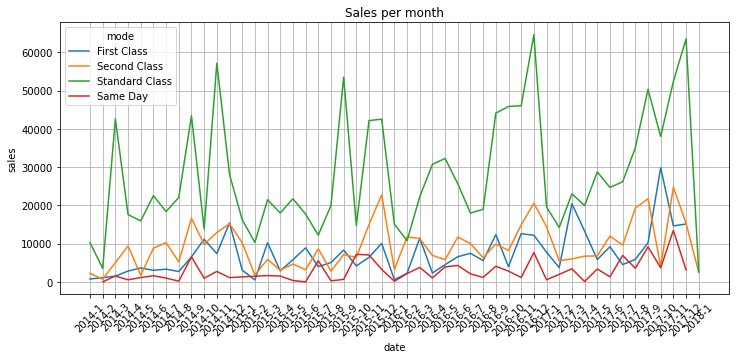

In [69]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_mode_sum, x = "date", y="sales", hue = "mode")
plt.xticks(rotation = 45)
plt.title("Sales per month")
plt.grid()
plt.show()

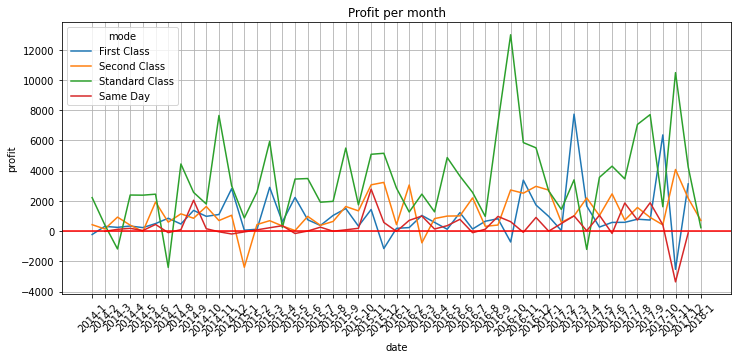

In [70]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_mode_sum, x = "date", y="profit", hue = "mode")
plt.xticks(rotation = 45)
plt.title("Profit per month")
plt.axhline(y=0, color = "red")
plt.grid()
plt.show()

<AxesSubplot:xlabel='profit', ylabel='Density'>

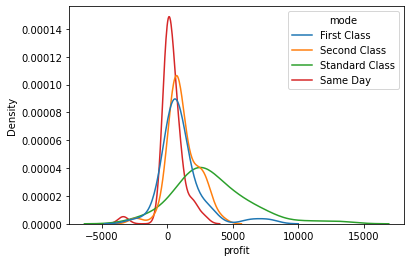

In [71]:
sns.kdeplot(data = monthly_mode_sum, x = "profit", hue = "mode")

<AxesSubplot:xlabel='sales', ylabel='Density'>

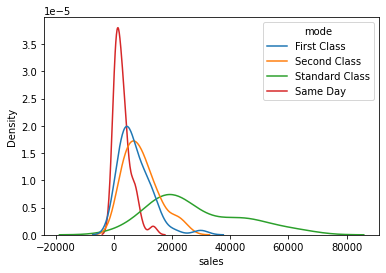

In [72]:
sns.kdeplot(data = monthly_mode_sum, x = "sales", hue = "mode")

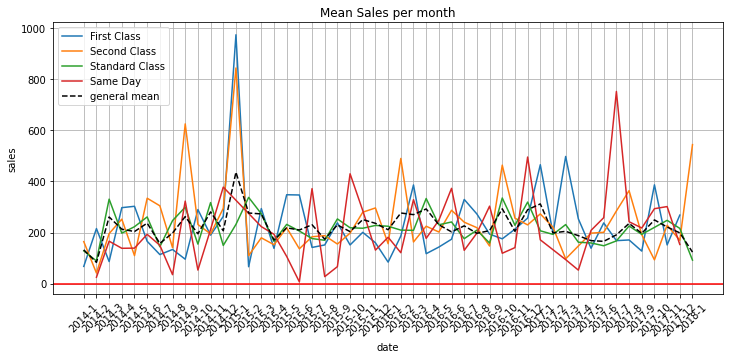

In [73]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_mode_mean, x = "date", y="sales", hue = "mode")
sns.lineplot(data = sales_month_mean, x = "date", y="sales", linestyle="--", color ="black", label="general mean")
plt.xticks(rotation = 45)
plt.title("Mean Sales per month")
plt.axhline(y=0, color = "red")
plt.grid()
plt.show()

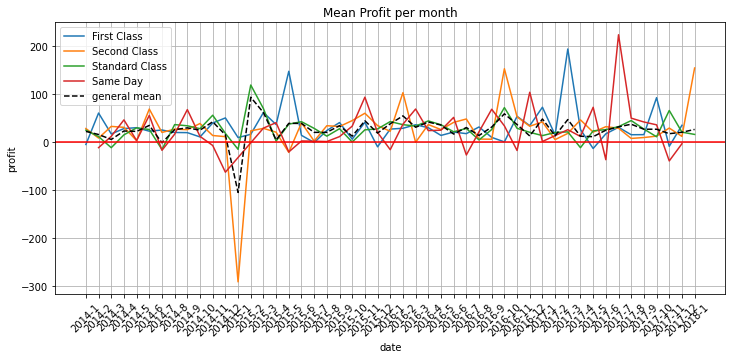

In [74]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_mode_mean, x = "date", y="profit", hue = "mode")
sns.lineplot(data = profit_monthly_mean, x = "date", y="profit", linestyle="--", color ="black", label="general mean")
plt.xticks(rotation = 45)
plt.title("Mean Profit per month")
plt.axhline(y=0, color = "red")
plt.grid()
plt.show()

In [75]:
monthly_mode_sum["cost"] = monthly_mode_sum["sales"]- monthly_mode_sum["profit"]

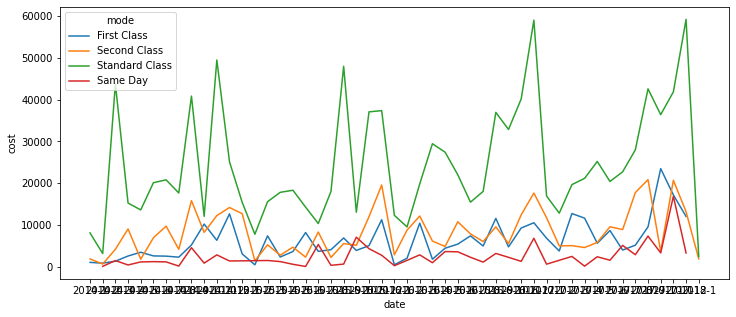

In [76]:
plt.figure(figsize = (12,5))
sns.lineplot(data = monthly_mode_sum, x = "date", y = "cost", hue = "mode")
plt.show()

In [77]:
monthly_mode_sum.groupby(["mode"])["cost"].describe()

,count,mean,std,min,25%,50%,75%,max
mode,,,,,,,,
First Class,48.0,6301.220479,4666.507295,407.3110,2893.19510,5055.96805,9293.413500,23458.9079
Same Day,44.0,2556.167411,2912.108247,14.0270,886.26135,1486.85735,3247.372275,16831.1901
Second Class,49.0,8198.917020,5339.566716,594.2895,4546.26680,6887.21460,11938.629600,20823.3971
Standard Class,49.0,24369.937867,13896.780467,2389.7459,15196.83770,20085.57980,36397.554300,59237.1153


In [78]:
df.groupby(["Ship Mode", "Category"])[["Profit"]].describe()

Profit                                    \
                                 count       mean         std        min   
Ship Mode      Category                                                    
First Class    Furniture         327.0   9.379044  118.507050 -1002.7836   
               Office Supplies   910.0  20.220142  142.605543 -2287.7820   
               Technology        301.0  91.370643  509.009288 -2639.9912   
Same Day       Furniture         119.0   6.700407  102.753447  -350.4900   
               Office Supplies   326.0  19.704047   54.550023  -336.6272   
               Technology         98.0  88.478483  509.754174 -3839.9904   
Second Class   Furniture         427.0   9.897568  155.542096 -1862.3124   
               Office Supplies  1152.0  23.496673  126.126319 -1065.3720   
               Technology        366.0  71.454116  208.945974  -643.7100   
Standard Class Furniture        1248.0   8.301855  136.127939 -1665.0522   
               Office Supplies  3638.0  19.405933  186.150250 -3701.8928   
               Technology       1082.0  76.829286  451.639815 -6599.9780   

                                                                          
                                      25%       50%       75%        max  
Ship Mode      Category                                                   
First Class    Furniture       -12.849000   6.37800  26.95380   673.8816  
               Office Supplies   2.111625   7.14330  19.77360  1906.4850  
               Technology        5.101500  23.51160  72.97500  6719.9808  
Same Day       Furniture       -13.471200   7.15920  30.17550   373.7790  
               Office Supplies   2.508500   6.48850  19.76900   459.9875  
               Technology        6.039750  33.99620  90.62935  2229.0240  
Second Class   Furniture        -7.435400   7.81660  38.28500   700.9800  
               Office Supplies   2.934000   7.96250  21.34950  2504.2216  
               Technology        6.830700  28.69305  73.53810  2799.9840  
Standard Class Furniture       -13.693275   8.10795  32.74260  1013.1270  
               Office Supplies   1.764000   6.56790  18.68100  4946.3700  
               Technology        4.797900  23.99770  71.83995  8399.9760

## Quantity Analysis

In [79]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'year',
       'month', 'day'],
      dtype='object')

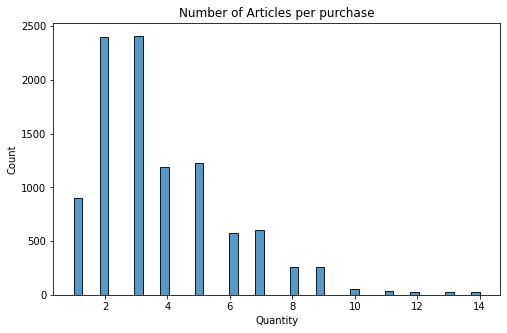

In [80]:
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = "Quantity")
plt.title("Number of Articles per purchase")
plt.show()

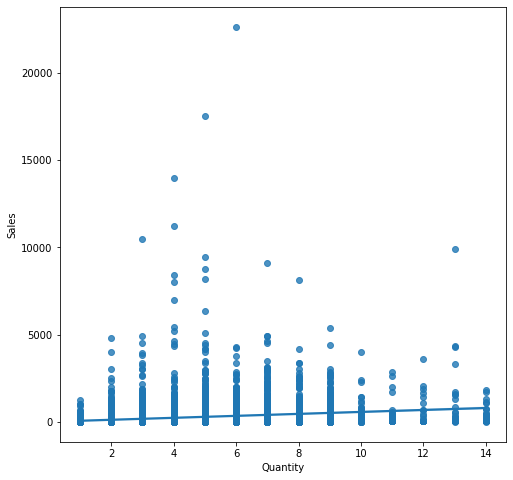

In [81]:
plt.figure(figsize = (8,8))
sns.regplot(data = df, x = "Quantity", y = "Sales")
plt.show()

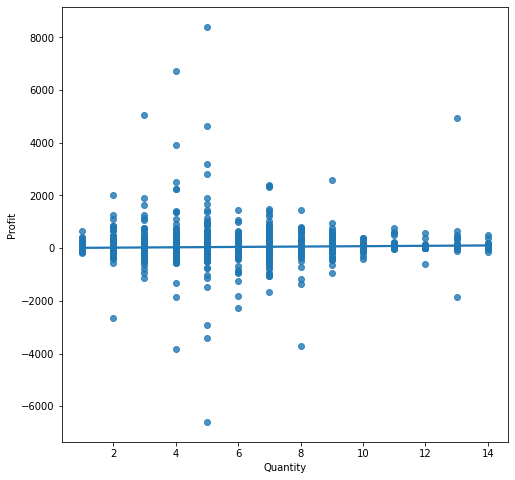

In [82]:
plt.figure(figsize = (8,8))
sns.regplot(data = df, x = "Quantity", y = "Profit")
plt.show()

Is there any prefered Ship Mode with the Quantity?

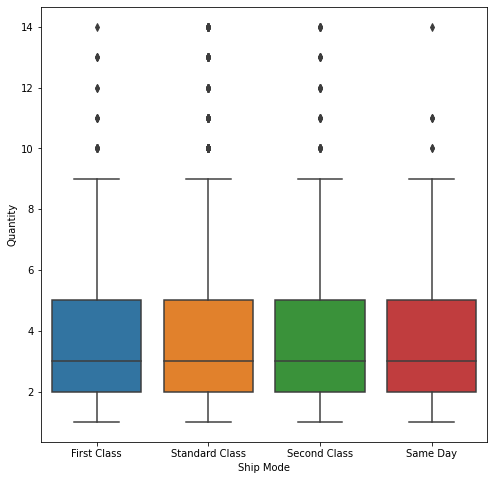

In [83]:
plt.figure(figsize = (8,8))
sns.boxplot(data = df, x = "Ship Mode", y = "Quantity")
plt.show()

## Discount Analysis

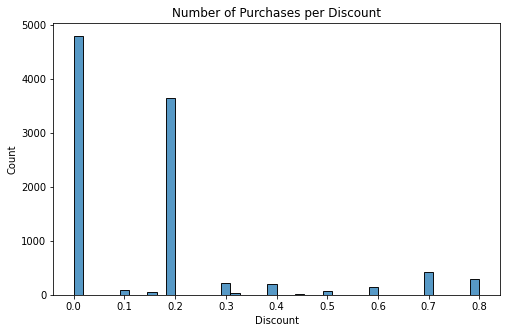

In [84]:
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = "Discount")
plt.title("Number of Purchases per Discount")
plt.show()

Which category gets the most Discounts?

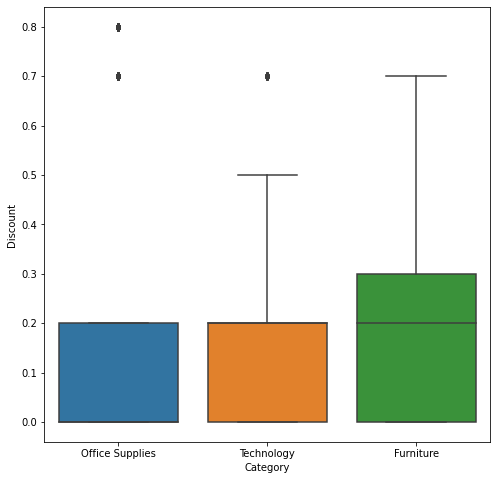

In [85]:
plt.figure(figsize = (8,8))
sns.boxplot(data = df, x = "Category", y = "Discount")
plt.show()

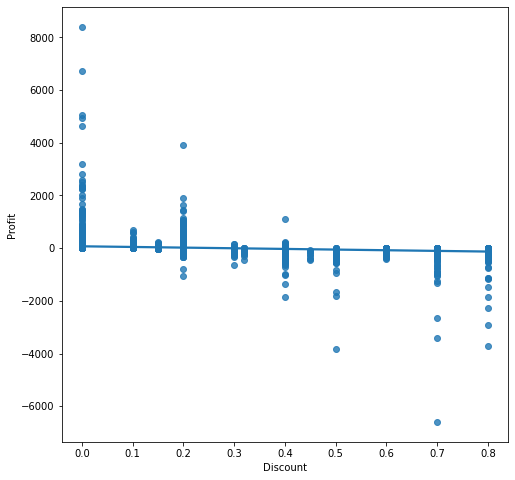

In [86]:
plt.figure(figsize = (8,8))
sns.regplot(data = df, x = "Discount", y = "Profit")
plt.show()

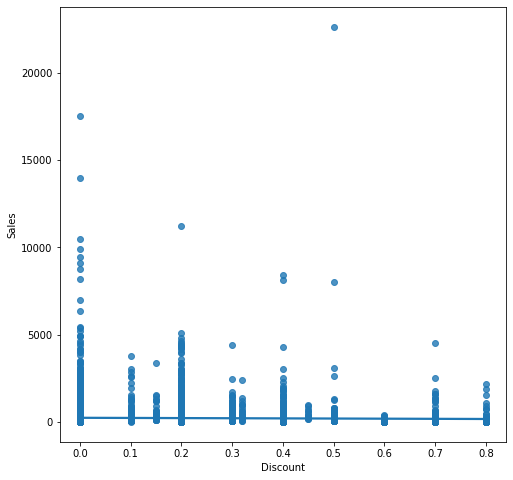

In [87]:
plt.figure(figsize = (8,8))
sns.regplot(data = df, x = "Discount", y = "Sales")
plt.show()

## Geography Analysis

In [88]:
import matplotlib.pyplot as plt
import geopandas as gpd
import shapefile as shp

import geoplot
import geoplot.crs as gcrs

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


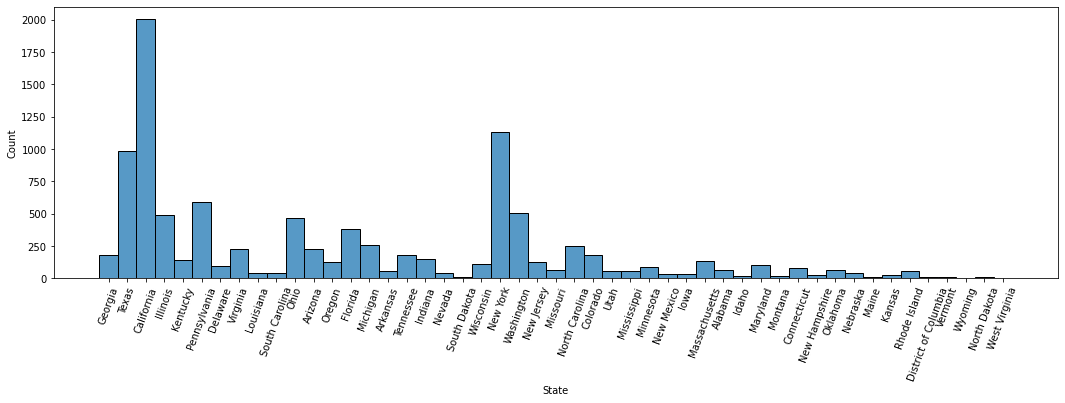

In [89]:
plt.figure(figsize = (18,5))
sns.histplot(data = df, x = "State")
plt.xticks(rotation = 70)
plt.show()

In [90]:
states = gpd.read_file("../input/usa-states-geojson/us-states.json")
states = states.to_crs("EPSG:4326")

In [91]:
# dropping Hawaii and Alaska
states = states.drop([1,10], axis = 0)

In [92]:
state_sales = pd.DataFrame(df.groupby(["State", "year"]).sum()["Sales"])
state_sales.reset_index(inplace=True)
state_sales = state_sales.rename(columns = {'State': 'name', "Sales":"sales"})


In [93]:
states_info = pd.DataFrame(df.groupby(["State"]).sum()[["Sales", "Profit"]])
states_info.reset_index(inplace=True)
states_info = states_info.rename(columns = {'State': 'name'})

states_poly = states.merge(states_info, on="name")

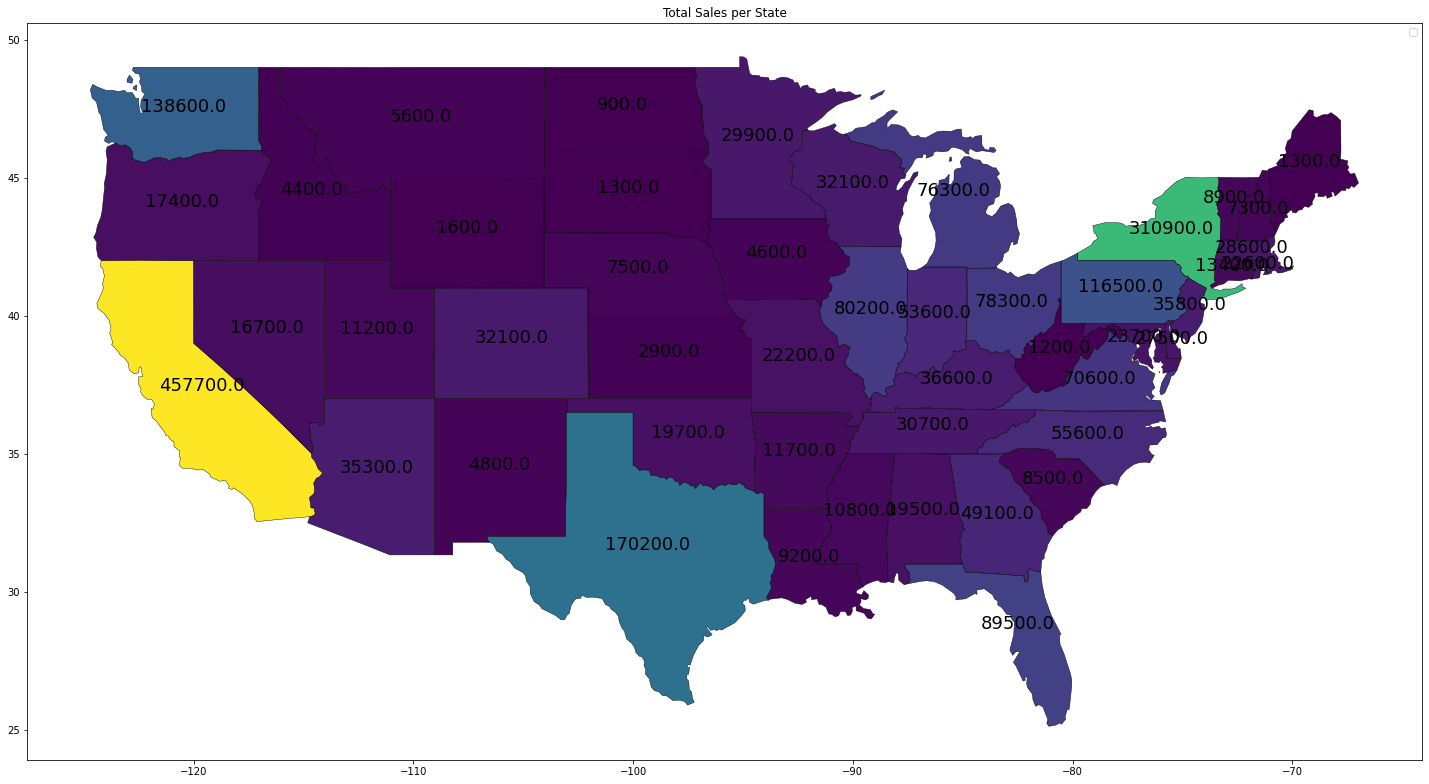

In [94]:
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
states_poly.apply(lambda x: ax.annotate(text=np.round(x.Sales,-2), xy=x.geometry.centroid.coords[0], ha='center', fontsize=18, color = "black"),axis=1);
states_poly.boundary.plot(ax=ax, color='black', linewidth=.4)
states_poly.plot(ax=ax, column='Sales',cmap='viridis', figsize=(12, 12))
ax.legend()
ax.set_title("Total Sales per State")
plt.show()

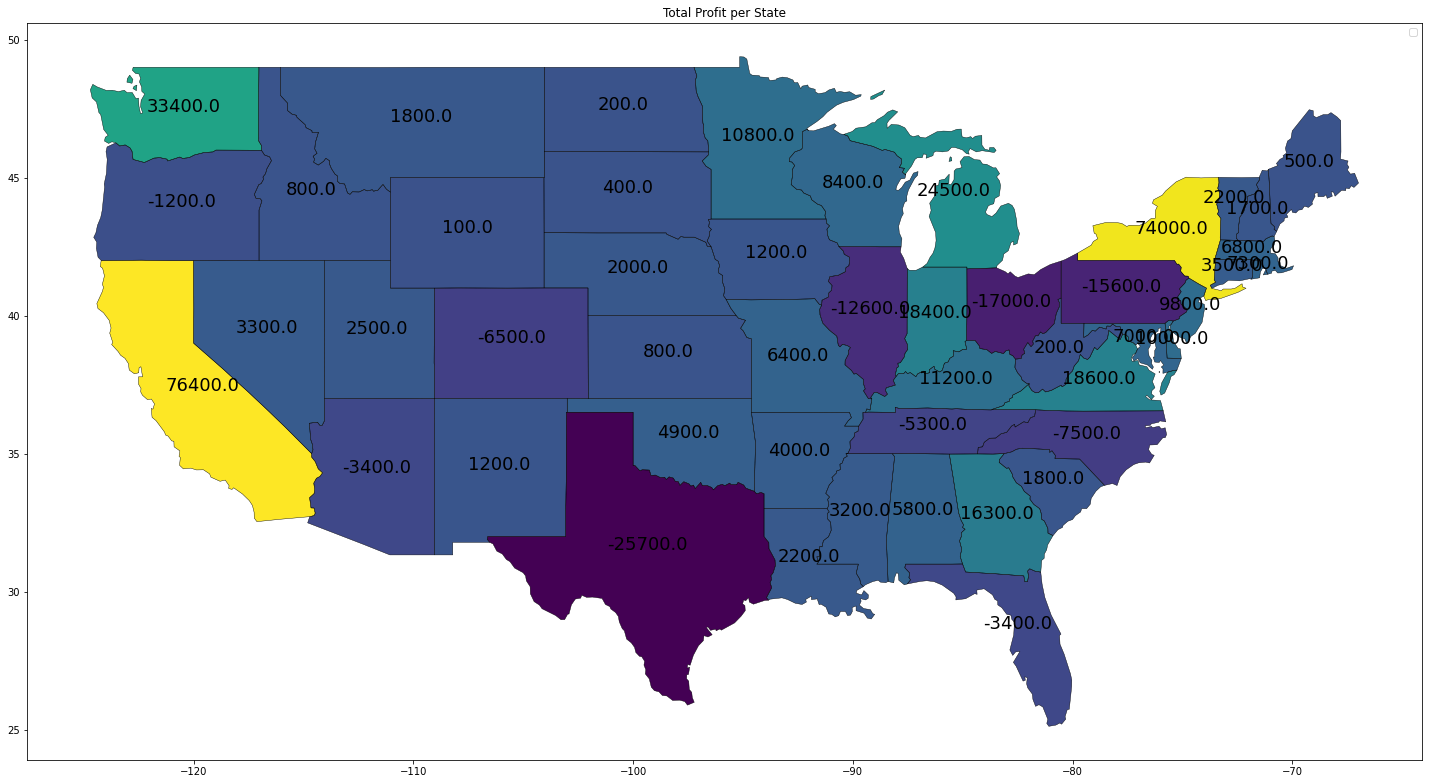

In [95]:
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
states_poly.apply(lambda x: ax.annotate(text=np.round(x.Profit,-2), xy=x.geometry.centroid.coords[0], ha='center', fontsize=18, color = "black"),axis=1);
states_poly.boundary.plot(ax=ax, color='black', linewidth=.4)
states_poly.plot(ax=ax, column='Profit',cmap='viridis', figsize=(12, 12))
ax.legend()
ax.set_title("Total Profit per State")
plt.show()

## RFM Analysis

In [96]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'year',
       'month', 'day'],
      dtype='object')

In [97]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

def RFM_Analysis(data_df):
    data_df = data_df.dropna()
    RFM = data_df["Customer ID"].drop_duplicates()

      # RECENCY
    max_purchase = data_df.groupby("Customer ID")["Ship Date"].max().reset_index()
    max_purchase.columns = ['Customer ID','MaxPurchaseDate']
    max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
    Recency = max_purchase.drop(['MaxPurchaseDate'],axis = 1)
    RFM = pd.merge(RFM, Recency, on = 'Customer ID', how = 'left')

    DF = RFM[["Recency"]]
    kmeans = KMeans(n_clusters=5)
    RFM["Cluster_Recency"] = kmeans.fit_predict(DF)

    RFM = order_cluster('Cluster_Recency', 'Recency',RFM,False)

    # FREQUENCY
    freq = data_df.groupby("Customer ID")["Ship Date"].count().reset_index()
    freq.columns = ['Customer ID','Frequency']

    RFM = pd.merge(RFM, freq, how = 'left', on = "Customer ID")

    DF = RFM[["Frequency"]]
    kmeans = KMeans(n_clusters=5)
    RFM["Cluster_Frequency"] = kmeans.fit_predict(DF)

    RFM = order_cluster('Cluster_Frequency', 'Frequency',RFM,True)

    # MONETARY
    monetary = data_df.groupby('Customer ID').Sales.mean().reset_index()
    monetary.columns = ['Customer ID', 'Monetary']

    RFM = pd.merge(RFM, monetary, how = 'left', on = 'Customer ID')

    DF = RFM[["Monetary"]]
    kmeans = KMeans(n_clusters=5)
    RFM["Cluster_Monetary"] = kmeans.fit_predict(DF)
    RFM = order_cluster('Cluster_Monetary', 'Monetary',RFM,True)

    RFM["RFM_Score"] = RFM.Cluster_Recency + RFM.Cluster_Frequency + RFM.Cluster_Monetary

    RFM['Segment'] = 'Low-Value' # 0-3
    RFM.loc[RFM['RFM_Score']>3,'Segment'] = 'Mid-Value' # 4 - 6
    RFM.loc[RFM['RFM_Score']>6,'Segment'] = 'High-Value' # + 6

    return(RFM)

In [98]:
RFM = RFM_Analysis(df)

In [99]:
RFM.columns

Index(['Customer ID', 'Recency', 'Cluster_Recency', 'Frequency',
       'Cluster_Frequency', 'Monetary', 'Cluster_Monetary', 'RFM_Score',
       'Segment'],
      dtype='object')

In [100]:
low_customers = np.array(RFM[RFM.Segment == "Low-Value"]["Customer ID"])
mid_customers = np.array(RFM[RFM.Segment == "Mid-Value"]["Customer ID"])
high_customers = np.array(RFM[RFM.Segment == "High-Value"]["Customer ID"])

In [101]:
idx_low = []
idx_mid = []
idx_high = []
for i in df.index:
    if df["Customer ID"][i] in low_customers:
        idx_low.append(i)
    elif df["Customer ID"][i] in mid_customers:
        idx_mid.append(i)
    elif df["Customer ID"][i] in high_customers:
        idx_high.append(i)
print(len(idx_low))
print(len(idx_mid))
print(len(idx_high))

909
3807
5278


In [102]:
df["RFM"] = "Low"
df.iloc[idx_mid, -1] = "Mid"
df.iloc[idx_high, -1] = "High"

In [103]:
df.RFM.unique()

array(['Low', 'Mid', 'High'], dtype=object)

In [104]:
df.groupby("RFM").count()["Row ID"]

RFM
High    5278
Low      909
Mid     3807
Name: Row ID, dtype: int64

<AxesSubplot:xlabel='RFM', ylabel='Profit'>

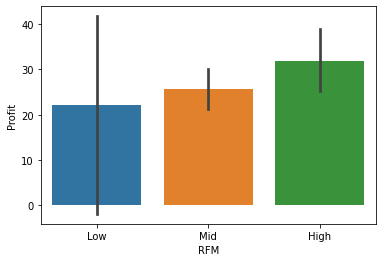

In [105]:
sns.barplot(data = df, x= "RFM", y = "Profit")